# Installations that cause frequent errors on TPU

In [1]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 4.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


# Set Environment

In [2]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import matplotlib.pyplot as plt
import pandas as pd

import pickle
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, BatchNormalization, Activation, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import gc

D0911 09:52:57.573328997      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0911 09:52:57.573368115      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0911 09:52:57.573371650      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0911 09:52:57.573374387      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0911 09:52:57.573376892      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0911 09:52:57.573379648      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0911 09:52:57.573382264      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0911 09:52:57.

TensorFlow version: 2.12.0


# Set Seed for Reproducibility

In [3]:
def set_seed(seed=21019):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Loading data splits and one-hot encoding

In [4]:
print('Loaing data ...')
with open('/kaggle/input/data-split-for-cyenet/data_splits_for_cyenet.pkl', 'rb') as f:
    loaded_splits = pickle.load(f)

x_train = loaded_splits['x_train']
x_val = loaded_splits['x_val']
x_test = loaded_splits['x_test']
y_train = loaded_splits['y_train']
y_val = loaded_splits['y_val']
y_test = loaded_splits['y_test']

y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)
y_test_encoded = to_categorical(y_test)

print(f'Samples in Train Set: {len(y_train_encoded)}')
print(f'Samples in Validation Set: {len(y_val_encoded)}')
print(f'Samples in Test Set: {len(y_test_encoded)}')

Loaing data ...
Samples in Train Set: 10044
Samples in Validation Set: 2512
Samples in Test Set: 3140


# Creating the CYENET model

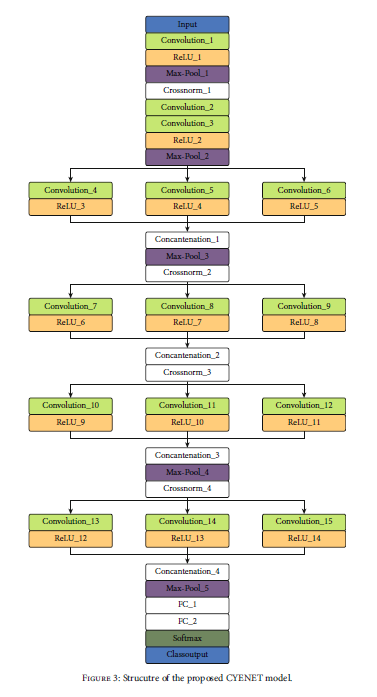

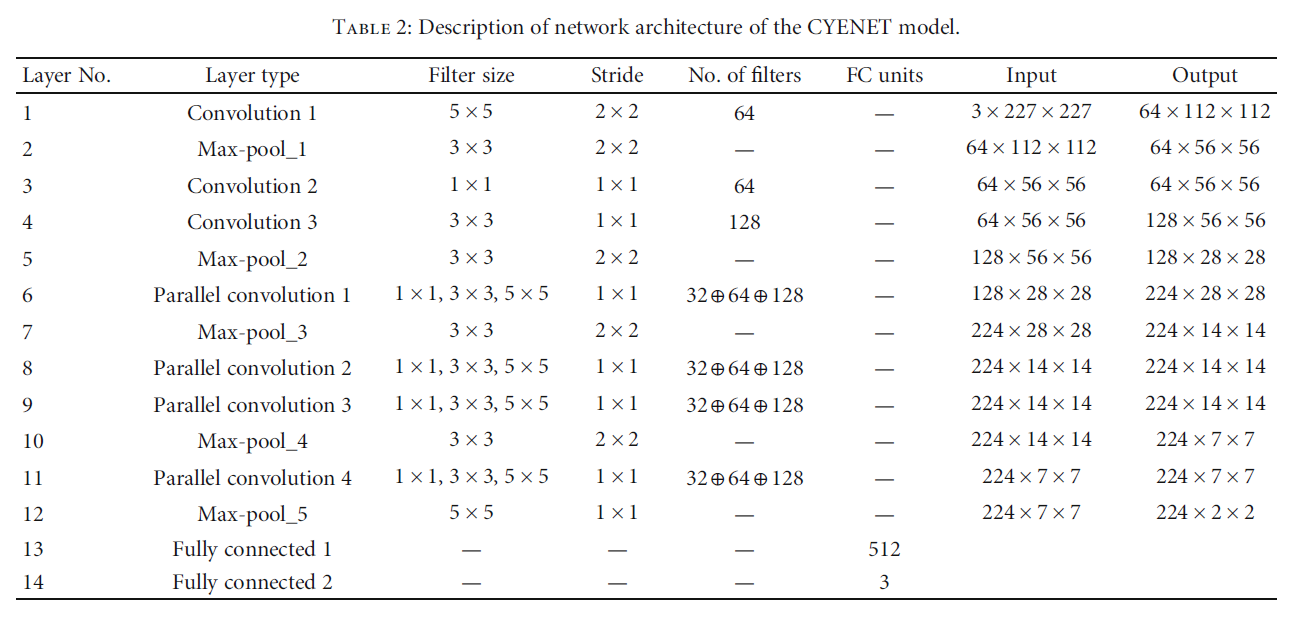

In [5]:
# Define class names
class_names = list(['Type 1','Type 2','Type 3'])

# Parallel convolution block
def parallel_conv_block(x_in):
    # First convolutional branch
    conv1 = Conv2D(32, 3, padding='same')(x_in)
    conv1 = Activation('relu')(conv1)
    
    # Second convolutional branch
    conv2 = Conv2D(64, 3, padding='same')(x_in)
    conv2 = Activation('relu')(conv2)
    
    # Third convolutional branch
    conv3 = Conv2D(128, 3, padding='same')(x_in)
    conv3 = Activation('relu')(conv3)
    
    # Concatenate the outputs of the three branches
    x_out = Concatenate()([conv1, conv2, conv3])
    
    return x_out

# Define the input shape
input_shape = x_train[0].shape

# Define the input tensor
inputs = Input(shape=input_shape)

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # First Convolutional Block
    x = Conv2D(64, 5, strides=2)(inputs)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, 1, strides=1)(x)
    x = Conv2D(128, 3, strides=1, padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    # First parallel convolution
    x = parallel_conv_block(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    # Second parallel convolution
    x = parallel_conv_block(x)
    x = BatchNormalization()(x)
    # Third parallel convolution
    x = parallel_conv_block(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    # Fourth parallel convolution
    x = parallel_conv_block(x)
    x = MaxPooling2D(pool_size=5, strides=2)(x)

    # Flatten before dense layers
    x = Flatten()(x)

    # Output layers fully connected with random initialization
    x = Dense(512, activation='relu')(x)
    x = Dense(len(class_names))(x)
    outputs = Activation('softmax')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Print the summary of the model
model.summary()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  4864        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [6]:
# Plot the model
tf.keras.utils.plot_model(
    model,
    to_file="CYENETreplicated.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=600,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train Model

In [7]:
# Remove garbage to free up memory
print(f'Freeing up memory!')
gc.collect()

# Create the Learning Rate callback
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-10)

# Define the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint('CYENET_best_model.h5', monitor='val_loss', save_best_only=True)

# Define the early stopping callback to stop training if validation loss does not improve
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with history tapping (keeps data in a dictionary)
epochs = 50
batch_size = 32 * tpu_strategy.num_replicas_in_sync
history = model.fit(x_train, y_train_encoded, 
                    validation_data=(x_val,y_val_encoded),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[lr_callback,checkpoint_callback,early_stopping_callback],
                    shuffle=True)

Freeing up memory!
Epoch 1/50


2023-09-11 09:54:16.818196: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-11 09:54:17.033563: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


40/40 [==============================] - ETA: 0s - loss: 1.6288 - accuracy: 0.4401

2023-09-11 09:54:41.412938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-09-11 09:54:41.535526: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


40/40 [==============================] - 41s 671ms/step - loss: 1.6288 - accuracy: 0.4401 - val_loss: 1.9454 - val_accuracy: 0.3352 - lr: 0.0010
Epoch 2/50
40/40 [==============================] - 5s 114ms/step - loss: 1.0091 - accuracy: 0.4938 - val_loss: 1.1772 - val_accuracy: 0.3495 - lr: 0.0010
Epoch 3/50
40/40 [==============================] - 5s 116ms/step - loss: 0.9243 - accuracy: 0.5496 - val_loss: 1.0737 - val_accuracy: 0.4291 - lr: 0.0010
Epoch 4/50
40/40 [==============================] - 4s 100ms/step - loss: 0.8739 - accuracy: 0.5842 - val_loss: 1.1207 - val_accuracy: 0.4379 - lr: 0.0010
Epoch 5/50
40/40 [==============================] - 4s 102ms/step - loss: 0.8384 - accuracy: 0.6069 - val_loss: 1.2382 - val_accuracy: 0.4013 - lr: 0.0010
Epoch 6/50
40/40 [==============================] - 4s 111ms/step - loss: 0.8019 - accuracy: 0.6233 - val_loss: 1.0296 - val_accuracy: 0.4845 - lr: 0.0010
Epoch 7/50
40/40 [==============================] - 4s 112ms/step - loss: 0.6773

# Evaluate Model

In [8]:
CYENET_best_model = tf.keras.models.load_model('CYENET_best_model.h5')
loss, accuracy = CYENET_best_model.evaluate(x_test, y_test_encoded)
print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

99/99 [==============================] - 7s 68ms/step - loss: 0.3994 - accuracy: 0.8583
Test loss: 0.3994
Test accuracy: 0.8583


# Classification Report

In [9]:
# Get the true labels and predicted probabilities for the test data
# Make predictions on new images
predictions = CYENET_best_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate the classification report
report = classification_report(y_test, predicted_classes, target_names=class_names)
print("Classification Report:\n", report)

99/99 [==============================] - 7s 64ms/step
Classification Report:
               precision    recall  f1-score   support

      Type 1       0.92      0.94      0.93      1030
      Type 2       0.82      0.77      0.79      1042
      Type 3       0.84      0.86      0.85      1068

    accuracy                           0.86      3140
   macro avg       0.86      0.86      0.86      3140
weighted avg       0.86      0.86      0.86      3140



# Confusion Matrix

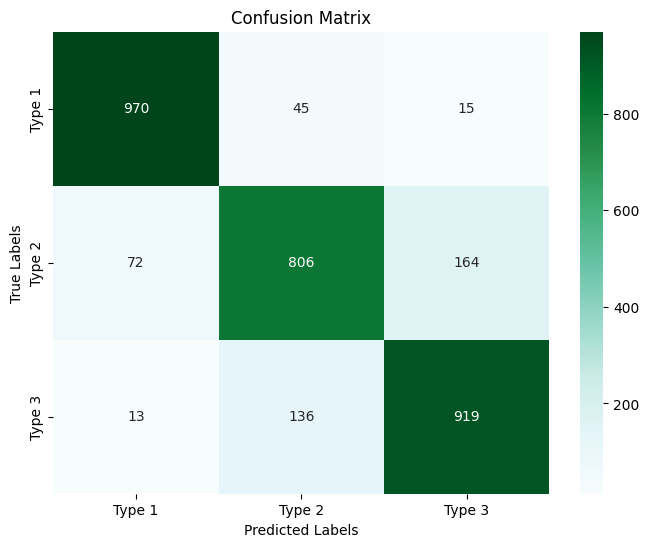

In [10]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Taining Curves

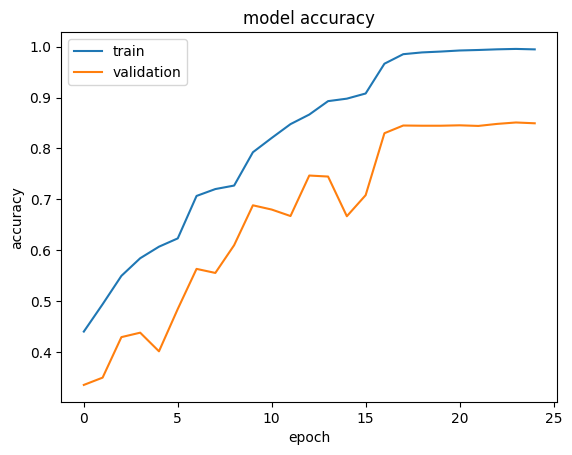

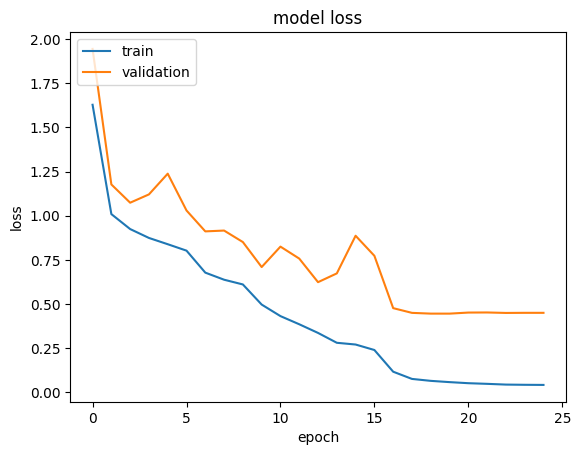

In [11]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()